<a href="https://colab.research.google.com/github/ma850419/FlexibleNet/blob/main/Welcome_To_Colaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from osgeo import gdal
#filepath = r'/content/PRS_L1_STD_OFFL_20221217082013_20221217082018_0001_HCO_VNIR.tif'
#filepath = r'/content/Sub_Sentinel2_.tif'
filepath = r'/content/All_b_CompositeBands1.tif'
# https://stackoverflow.com/questions/43684072/how-to-import-multiple-bands-from-an-image-into-numpy
# Load one GeoTIFF image using GDAL
dataset = gdal.Open(filepath)
#nodata_value = dataset.GetRasterBand(1).GetNoDataValue()
projInfo = dataset.GetProjection()
trans = dataset.GetGeoTransform()
print(projInfo,dataset.RasterXSize,dataset.RasterYSize,dataset.RasterCount )
#print(me)
#image = np.zeros(( dataset.RasterXSize,dataset.RasterYSize,dataset.RasterCount))
image = dataset.ReadAsArray()
#image3 = np.transpose(image,(1,2,0))
  # <class 'numpy.ndarray'>
#print(image2.shape) 
#print(image.dtype)  
print(image1.dtype)

In [ ]:
!pip install pysptools
!pip install spectral

In [ ]:
from __future__ import print_function

import os
import os.path as osp
import pysptools.classification as cls
import matplotlib.pyplot as plt
import pysptools.util as util
import pysptools.eea as eea
import pysptools.abundance_maps as amp

import numpy as np

n_emembers = 8


def parse_ENVI_header(head):
    ax = {}
    ax['wavelength'] = head['wavelength']
    ax['x'] = 'Wavelength - '+head['z plot titles'][0]
    ax['y'] = head['z plot titles'][1]
    return ax


class Classify(object):
    """
    For this problem NormXCorr works as well as SAM
    SID was not tested.
    """

    def __init__(self, data, E, path, threshold, suffix):
        print('Classify using SAM')
        self.sam = cls.SAM()
        self.sam.classify(data, E, threshold=threshold)
        self.path = path
        self.suffix = suffix

    def get_single_map(self, idx):
        return self.sam.get_single_map(idx, constrained=False)

    def plot_single_map(self, idx):
        self.sam.plot_single_map(self.path, idx, constrained=False, suffix=self.suffix)

    def plot(self):
        self.sam.plot(self.path, suffix=self.suffix)


def get_endmembers(data, header, q, path, mask, suffix, output=False):
    print('Endmembers extraction with NFINDR')
    ee = eea.NFINDR()
    U = ee.extract(data, q, maxit=5, normalize=True, ATGP_init=True, mask=mask)
    if output == True:
        ee.plot(path, axes=header, suffix=suffix)
    return U


def get_abundance_maps(data, U, umix_source, path, output=False):
    print('Abundance maps with FCLS')
    fcls = amp.FCLS()
    amap = fcls.map(data, U, normalize=True)
    if output == True:
        fcls.plot(path, colorMap='jet', suffix=umix_source)
    return amap


def get_full_cube_em_set(data, header, path):
    """ Return a endmembers set for the full cube and a region of interest (ROI).
        The ROI is created using a small region of the
        effluents leaving near the smokestack.
    """
    # Take the endmembers set for all the cube
    U = get_endmembers(data, header, n_emembers, path, None, 'full_cube', output=True)
    # A threshold of 0.15 give a good ROI
    cls = Classify(data, U, path, 0.15, 'full_cube')
    # The endmember EM2 is use to define the region of interest
    # i.e. the effluents region of interest
    effluents = cls.get_single_map(2)
    # Create the binary mask with the effluents
    mask = (effluents > 0)
    # Plot the mask
    plot(mask, 'gray', 'binary_mask', path)
    return U, mask


def get_masked_em_set(data, header, path, mask):
    """ Return a endmembers set that belong to the ROI (mask).
    """
    # Use the mask to extract endmembers near the smokestack exit
    U = get_endmembers(data, header, n_emembers, path, mask, 'masked', output=True)
    return U


def classification_analysis(data, path, E_masked):
    # Note: the classification is done with NormXCorr instead of SAM
    # Classify with the masked endmembers set
    c = cls.NormXCorr()
    c.classify(data, E_masked, threshold=0.15)
    c.plot_single_map(path, 'all', constrained=False, suffix='masked')
    c.plot(path, suffix='masked')
    # Calculate the average image
    gas = c.get_single_map(1, constrained=False)
    for i in range(n_emembers - 1):
        gas = gas + c.get_single_map(i+2, constrained=False)
    gas = gas / n_emembers
    # and plot it
    plot(gas, 'spectral', 'mean_NormXCorr', path)


def unmixing_analysis(data, path, E_full_cube, E_masked):
    # Calculate an unmixed average image at the ROI position.
    # Each endmember belonging to E_masked takes place inside E_full_cube at
    # the ROI position. Netx, we sum the abundance maps
    # generated at this position. And finally a mean is calculated.
    for i in range(n_emembers):
        E_full_cube[1,:] = E_masked[i,:]
        amaps = get_abundance_maps(data, E_full_cube, 'masqued_{0}'.format(i+1), path, output=False)
        if i == 0:
            mask = amaps[:,:,1]
        else:
            mask = mask + amaps[:,:,1]
        plot(amaps[:,:,1], 'spectral', 'FCLS_masqued_{0}'.format(i+1), path)
    mask = mask / n_emembers
    thresholded = (mask > 0.15) * mask
    plot(thresholded, 'spectral', 'mean_FCLS', path)


def plot(image, colormap, desc, path):
    plt.ioff()
    img = plt.imshow(image, interpolation='none')
    img.set_cmap(colormap)
    plt.colorbar()
    fout = osp.join(path, '{0}.png'.format(desc))
    plt.savefig(fout)
    plt.clf()

In [ ]:
#
#------------------------------------------------------------------------------
# Copyright (c) 2013-2014, Christian Therien
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#------------------------------------------------------------------------------
#
# envi.py - This file is part of the PySptools package.
#

"""
load_ENVI_file, load_ENVI_spec_lib functions
"""


import numpy as np
import spectral.io.envi as envi

def load_ENVI_file(file_name):
    """
    Load the data and the header from an ENVI file.
    It use the SPy (spectral) library. At 'file_name' give the envi header file name.
    Parameters:
        file_name: `path string`
            The complete path to the file to load. Use the header file name.
    Returns: `tuple`
        data: `numpy array`
            A (m x n x p) HSI cube.
        head: `dictionary`
            Starting at version 0.13.1, the ENVI file header
     """
    img = envi.open(file_name)
    head = envi.read_envi_header(file_name)
    return np.array(img.load()), head


def load_ENVI_spec_lib(file_name):
    """
    Load a ENVI .sli file.
    Parameters:
        file_name: `path string`
            The complete path to the library file to load.
    Returns: `numpy array`
        A (n x p) HSI cube.
        head: `dictionary`
            Starting at version 0.13.1, the ENVI file header
    """
    sli = envi.open(file_name)
    head = envi.read_envi_header(file_name)
    return sli.spectra, head

In [19]:
if __name__ == '__main__':
    # Load the cube
    data_path = '/content/'
    home = '/content/'
    result_path = os.path.join(home, 'results')

    sample = 'testhyperion.hdr'

    data_file = osp.join(data_path, sample)
    data, header = load_ENVI_file(data_file)

    if osp.exists(result_path) == False:
        os.makedirs(result_path)

    axes = parse_ENVI_header(header)

    # Telops cubes are flipped left-right
    # Flipping them again restore the orientation
    #data = np.fliplr(data)
    print(data.shape)
    U = get_endmembers(data, axes, 16, result_path, mask=None, suffix=None)
    amaps = get_abundance_maps(data, U, None, result_path)
  
    # EM4 == quartz
    quartz = amaps[:,:,3]
    plot(quartz, 'spectral', 'quartz', result_path)

    # EM1 == background, we use the backgroud to isolate the drill core
    # and define the mask
    mask = (amaps[:,:,0] < 0.2)
    plot(mask, 'spectral', 'mask', result_path)

    # Plot the quartz in color and the hematite in gray
    plot(np.logical_and(mask == 1, quartz <= 0.001) + quartz, 'spectral', 'hematite+quartz', result_path)

    # pixels stat
    rock_surface = np.sum(mask)
    quartz_surface = np.sum(quartz > 0.16)
    print('Some statistics')
    print('  Drill core surface (mask) in pixels:', rock_surface)
    print('  Quartz surface in pixels:', quartz_surface)
    print('  Hematite surface in pixels:', rock_surface - quartz_surface)

(1872, 1052, 198)
Endmembers extraction with NFINDR
Abundance maps with FCLS


ValueError: ignored

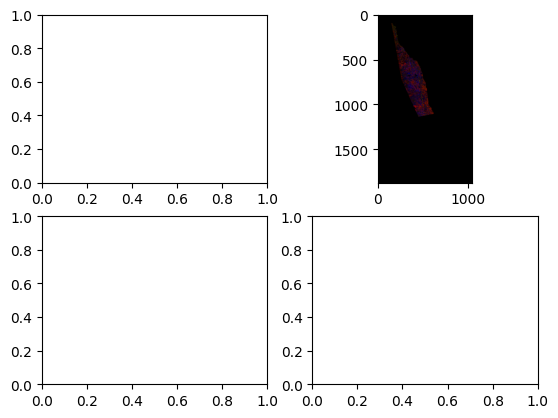

In [24]:
import matplotlib.pyplot as plt
clustered3 = np.zeros((1872, 1052,3))
f, axarr = plt.subplots(2,2)
clustered3[:,:,0]=amaps[:,:,5]
clustered3[:,:,1]=amaps[:,:,6]
clustered3[:,:,2]=amaps[:,:,9]
axarr[0,1].imshow(clustered3)
plt.show()

In [ ]:
!unzip /content/testhyperion.zip

In [ ]:
import matplotlib.pyplot as plt
#from PIL import ImageEnhance
#print(projInfo,image )
f, axarr = plt.subplots(2,2)
image3 = np.transpose(image1,(1,2,0))
clustered3 = np.zeros((159,158,3))
image4 = np.zeros((160,160,10))
image5 = np.zeros((160,160,10))
clustered3[:,:,0]=image3[:,:,5]
clustered3[:,:,1]=image3[:,:,7]
clustered3[:,:,2]=image3[:,:,3]
#enh = ImageEnhance.Contrast(clustered3)
#enh.enhance(1.8).show("30% more contrast")
#clustered3 = ((clustered3 - clustered3.min()) / (clustered3.max()-clustered3.min())) * 255
axarr[0,1].imshow(clustered3)
image2 = np.transpose(image,(1,2,0))
clustered3 = np.zeros((159,158,3))
clustered3[:,:,0]=image2[:,:,5]
clustered3[:,:,1]=image2[:,:,7]
clustered3[:,:,2]=image2[:,:,3]
print(clustered3)
axarr[1,1].imshow(clustered3)
plt.show()
image4[0:159,0:158,:]=image2
image5[0:159,0:158,:]=image3
image4[159:160,158:160,:]=0
image5[159:160,158:160,:]=0
print(image4.shape, image5.shape)


In [ ]:
#rast_arr= np.transpose(image2,(2,0,1))
rast_arr=image
print(rast_arr.shape)

In [ ]:
!pip install minisom

In [ ]:
import statistics
from minisom import MiniSom
mine=np.zeros((1231*1245,63))
pixels2=np.zeros((1231*1245,63))
pixels3=np.zeros((1231*1245,63))
som_clustered=np.zeros((1231*1245,63))
som = MiniSom(4, 4, 63, sigma=0.5,learning_rate=0.1, neighborhood_function='gaussian')
#mine=zeros((512*512,4))
#pixels2=zeros((600,512*512,4))
#som_clustered=zeros((600,512*512,1))
#for i in range(600):
pixels2= image2.reshape(1231*1245,63)
pixels3 = pixels2 != -999
pixels2 = abs(pixels2)*pixels3/300.0
#print( pixels2.min())
som.random_weights_init(pixels2)
starting_weights = som.get_weights().copy()  # saving the starting weights
som.train(pixels2, 10000, random_order=False, verbose=True)
print('quantization...')
qnt = som.quantization(pixels2)  # quantize each pixels of the image
    #print(qnt.shape)
clustered = np.zeros((1231*1245,63))
clustered1 = np.zeros((1231*1245,1))
for j, q in enumerate(qnt):  # place the quantized values into a new image
  sn = np.unravel_index(j,shape=((1231*1245)))
    #print(sn)
    #print(me)
   
  #print(q,(mean(q)*6).astype(np.uint8))
  #print(me)
  clustered[sn] = q[:] #(max(q)*6).astype(np.uint8) 
  #print(q[:]*255,round(q[:].max()*255))
  #print(me)
  #print((round(q[:].max()*16*300.0)))
  #print(me)
  clustered1[sn] = (round(q[:].max()*255))#.astype(np.uint8) #statistics.mean(q)
 # print(clustered1[sn])
        #print(clustered.shape)
#mine= np.append(mine,clustered,axis=0)#,axis=0)
   # print(clustered1)
#som_clustered[i] =  clustered1
    #print(som_clustered[i])
    #print(me)
#print(mine.shape)

In [ ]:
import cv2
import matplotlib.pyplot as plt
#print(clustered.shape, clustered1.shape)
pixels2= pixels2.reshape((1231,1245,63))
clustered2 = np.zeros((1231,1245))
clustered3 = np.zeros((1231,1245,3))
clustered3[:,:,0]=pixels2[:,:,60]
clustered3[:,:,1]=pixels2[:,:,35]
clustered3[:,:,2]=pixels2[:,:,20]
clustered3 = cv2.pow(clustered3,0.6)
# Convert the image from BGR to HSV color space
clustered2 = clustered1.reshape(1231,1245)
f, axarr = plt.subplots(2,2)
plt.figure(figsize = (20,4))
axarr[0,0].imshow(clustered2)
#plt.show()
axarr[0,1].imshow(clustered3)
#plt.show()
clustered3[:,:,0]=pixels2[:,:,50]
clustered3[:,:,1]=pixels2[:,:,30]
clustered3[:,:,2]=pixels2[:,:,15]
clustered3 = cv2.pow(clustered3,0.7)
axarr[1,0].imshow(clustered3)
#plt.show()
clustered3[:,:,0]=pixels2[:,:,30]
clustered3[:,:,1]=pixels2[:,:,20]
clustered3[:,:,2]=pixels2[:,:,10]
axarr[1,1].imshow(clustered3)
plt.show()

In [ ]:
!ls -l

In [ ]:
#from osgeo import osr
output_file = "out7.tif"
#clustered2 = np.zeros((1231,1245))
#clustered2 = clustered1.reshape(1231,1245)
# Create gtif
#rast_arr= np.zeros((image.shape))
#rast_arr= np.copy((image))
#print(rast_arr)
#driver = gdal.GetDriverByName("GTiff")
#x_size = dataset.RasterXSize # Raster xsize
#y_size = dataset.RasterYSize # Raster ysize
nband = dataset.RasterCount # number of bands
NaN_rast=-999
#dst_ds = driver.Create(output_file, x_size, y_size,nband, gdal.GDT_Float32 )
# top left x, w-e pixel resolution, rotation, top left y, rotation, n-s pixel resolution
#dst_ds.SetGeoTransform( [ -180, 0.025, 0, 90, 0, -0.025 ] )
#print(clustered2[900:1000,900:1000], clustered2.dtype)
#print(me)
# set the reference info 
band = 0
if type(image) == tuple:
  print('0')
  rast_arr = np.array(image[band])
if str(type(dataset)) == "<class 'osgeo.gdal.Dataset'>":
  print('2')
  geo_transform = dataset.GetGeoTransform()
  x_size = dataset.RasterXSize  # Raster xsize
  y_size = dataset.RasterYSize  # Raster ysize
  #print(x_size,y_size)
  srs = dataset.GetProjectionRef()  # Projection
elif str(type(dataset)) == "<class 'affine.Affine'>":
  print('3')
  geo_transform = (dataset[2], dataset[0], dataset[1], dataset[5], dataset[3], dataset[4])
  rast_arr = image[band,:,:]
  x_size = int(rast_arr.shape[1])
  y_size = int(rast_arr.shape[0])
driver = gdal.GetDriverByName("GTiff")
dataset_out = driver.Create(output_file, x_size, y_size, nband, gdal.GDT_Float32)
    #end auxiliar
for band in range(1,nband):
  if type(image) == tuple:
    print('Iam ')
    rast_arr = np.array(image[band])
  if str(type(dataset)) == "<class 'osgeo.gdal.Dataset'>":
    print('Iam here')
    geo_transform = dataset.GetGeoTransform()
    x_size = dataset.RasterXSize  # Raster xsize
    y_size = dataset.RasterYSize  # Raster ysize
    #print(x_size,y_size)
    srs = dataset.GetProjectionRef()  # Projection
  elif str(type(dataset)) == "<class 'affine.Affine'>":
    print('Iam here here')
    geo_transform = (dataset[2], dataset[0], dataset[1], dataset[5], dataset[3], dataset[4])
    rast_arr = image[band,:,:]
    x_size = int(rast_arr.shape[1])
    y_size = int(rast_arr.shape[0])
        #PROCESS RASTERIO NUMPY
  else:
    print('Iam here here here')
    geo_transform = (dataset[1][2], dataset[1][0], dataset[1][1], dataset[1][5], dataset[1][3], dataset[1][4])
    rast_arr = np.array(dataset[0])
    x_size = int(rast_arr.shape[2])
    y_size = int(rast_arr.shape[1])
  rast_arr[rast_arr == NaN_rast] = np.NaN
  dataset_out.SetGeoTransform(geo_transform)
  dataset_out.SetProjection(srs)
  print(band)
  dataset_out.GetRasterBand(band).WriteArray(rast_arr[band,:,:])#.astype(np.float32))
#for band in range(1,nband):
  #dst_ds.SetGeoTransform(trans)
#dst_ds.ImportFromWkt(projInfo)
  #dst_ds.SetProjection( projInfo )
  #dst_ds.GetRasterBand(band).WriteArray(image)
#dst_ds.FlushCache()
#dst_ds = None


In [ ]:
def unique(list1):
 
    # insert the list to the set
    list_set = set(list1)
    # convert the set to the list
    unique_list = (list(list_set))
    #for x in unique_list:
        #print(x)
    return unique_list

In [ ]:
list1=[]
list1= np.append(list1,clustered)
#list1=clustered1.tolist()
l= np.zeros(60)
u=unique(list1)
print(u)


In [ ]:
a=plt.hist(clustered)
print(a)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
#from keras.utils import to_categorical
from keras.preprocessing import image
#import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import  confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
#from keras.utils import to_categorical
from tqdm import tqdm
#import pydot
#import pydot_ng as pydot
from keras.utils import plot_model
from keras.layers import Input, Dense, BatchNormalization

In [ ]:
#creating subimage of size 32X32
height=16
width = 16
#subim = np.zeros((38,32,32,63))
subim = np.zeros((10,16,16,10))
subim1 = np.zeros((10,16,16,10))
#imgwidth, imgheight, bands= image2[15:1231,29:1245,:].shape
imgwidth, imgheight, bands= image2[:,:,:].shape
imgwidth1, imgheight1, bands1= image3[:,:,:].shape
#print(imgwidth, imgheight, bands)
for k in range(0,10):
  for i in range(0,imgheight,height):
    for j in range(0,imgwidth,width):
      #box = (j, i, j+width, i+height)
      subim[k]= image4[j:j+width,i:i+height,:]
#print(imgwidth, imgheight, bands)
for k in range(0,10):
  for i in range(0,imgheight,height):
    for j in range(0,imgwidth,width):
      #box = (j, i, j+width, i+height)
      subim1[k]= image5[j:j+width,i:i+height,:]
#image3 = np.zeros((imgwidth, imgheight, bands))
#image3 = image2[15:1231,29:1245,:]
#print(imgwidth, imgheight, bands)
#for k in range(0,38):
 # for i in range(0,imgheight,height):
  #  for j in range(0,imgwidth,width):
      #box = (j, i, j+width, i+height)
  #    subim[k]= image3[j:j+width,i:i+height,:]
print(subim1, subim)

In [ ]:
from sklearn.model_selection import train_test_split
x_train,  x_test, y_train, y_test = train_test_split(subim1,subim,random_state=2020,test_size=0.2)
#x_train= train_images
#y_train =train_labels1
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)
#print(im1[0])
#x_test=train_images
#y_test = train_label
#x_train= train_images
#y_train =train_label
#print(x_test.shape)

In [ ]:
def build_unet(img_size,num_classes):
    # input layer shape is equal to patch image size
    inputs = keras.Input(shape=img_size + (10,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same",data_format='channels_last')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256, 512]:#, 256, 512]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same",data_format='channels_last')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same",data_format='channels_last')(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same",data_format='channels_last')(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same",data_format='channels_last')(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [512, 256, 128, 64]:# [512, 256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same",data_format='channels_last')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same",data_format='channels_last')(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2,data_format='channels_last')(x)

        # Project residual
        residual = layers.UpSampling2D(2,data_format='channels_last')(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same",data_format='channels_last')(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same",data_format='channels_last')(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

In [ ]:
import tensorflow as tf
img_size=(16, 16)
num_classes=10
model = build_unet(img_size,num_classes)
model.summary()

In [ ]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics = ["accuracy"])

In [ ]:
model.fit(x_train , y_train , epochs=50, steps_per_epoch=8, batch_size=4, validation_data=(x_test , y_test))

In [ ]:
import csv
from os import listdir
import numpy as np
import matplotlib.image as img
import pandas as pd
import os
from os.path import exists
from pathlib import Path

#with open('C:/Users/ma850/OneDrive/Documents/banana_spectral_signatures/banana_healthy_1a.dat', 'r') as dat_file:
 #   with open('C:/Users/ma850/OneDrive/Documents/banana_spectral_signatures/banana_healthy_1a.csv', 'w') as csv_file:
csv_dir =  r'/content/'
onlyfilenames = [f for f in listdir(csv_dir) if os.path.isfile(csv_dir+f)]
for file in onlyfilenames:
    print(file)
    filename, extension = os.path.splitext(file)
    if extension == '.csv':
        df = pd.read_csv(csv_dir+file,header =0)#, chunksize=1000)
        print(df.shape)
specsig = (df.iloc[:,:].values).astype('float32')
print(specsig.shape)

In [ ]:
#filtering A spectril signature

import numpy
print(specsig[:,0])
specsig[:,0:1]
import matplotlib.pyplot as plt
#plt.plot(specsig[:,0],specsig[:,1])
specsig1 = numpy.zeros((2151,30))
specsig2 = numpy.zeros((2151,30))
leng=len(specsig)
#print(leng)
specsig1[:,0] = specsig[:,0]
for i in range(leng):
    for j in range(1,30,1):
        if(specsig[i,j] >=0 and specsig[i,j] <= 1.0):
            specsig1[i,j]=specsig[i,j]
        else:
            specsig1[i,j]= 0
#print(specsig1[:,0:1])       
specsig2[:,0] = specsig[:,0]
specsig2[0:991,1:30]=specsig[0:991,1:30]
specsig2[991:1096,1:30]=specsig[991:1096,1:30]
specsig2[1096:1441,1:30]= specsig[1096:1441,1:30]
specsig2[1441:1606,1:30]=0
specsig2[1606:2151,1:30]= specsig[1606:2151,1:30]
print(specsig2.shape)
plt.subplot(1, 2 , 1) # row 1, col 2 index 1
#plt.plot(specsig2[0:991,0],specsig2[0:991,2],'b.')
#plt.plot(specsig2[1096:1441,0],specsig2[1096:1441,2],'b.')
#plt.plot(specsig2[1606:2100,0],specsig2[1606:2100,2],'b.')
plt.plot(specsig2[:,0],specsig2[:,1:],'b.')
plt.subplot(2, 2, 2) 
plt.plot(specsig[:,0],specsig[:,1:],'r^')
plt.show

In [ ]:
# reading FWHM file for prisma
csv_dir = "/content/"
file='wvfwmh_VNIR.csv'
df = pd.read_csv(csv_dir+file,header =0)
print(df.shape)
fwhm= (df.iloc[:,:].values).astype('float32')

In [ ]:
#resmapling spectral signatures to Prisma VNIR using FWHM
specsig3 = np.zeros((63,31))
specsig3[:,0]=fwhm[:,2]
specsig3[:,1]=fwhm[:,3]
for j in range(1,30):
   # n=0
    for i in range(0,63):
        f= round(fwhm[i,2])
        k= round(f+fwhm[i,3])
        s=0
        l=0
        for m in range (0,2151):
           
            if specsig2[m,0] >= f and specsig2[m,0]<=k:
                s= specsig2[m,j]+ s
                l=l+1
        av= s/l
        specsig3[i,j+1]= av
 